In [74]:
# Install required packages.
import os
import torch
os.environ['TORCH'] = torch.__version__
print(torch.__version__)

import pandas as pd
import numpy as np

# Helper function for visualization.
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

import torch_geometric.transforms as T
import torch.nn.functional as F
from torch_geometric.loader import DataLoader
from torch_geometric.datasets import OGB_MAG
from torch_geometric.nn import SAGEConv, to_hetero
# impoort HeteroData
from torch_geometric.data import HeteroData



1.13.1


In [75]:
# from torch_geometric.datasets import OGB_MAG
# import torch_geometric.transforms as T

# dataset = OGB_MAG(root='./data', preprocess='metapath2vec')
# data = dataset[0]

# print(data.metadata())
# data['institution'].x.shape
# data.x

In [76]:
# create a tensor of 84 nodes that are empty
# x = torch.empty(84, 0)
# x[0][0]

In [77]:
def node_df_to_torch(df: pd.DataFrame):
    return torch.tensor(df.values, dtype=torch.float)

def edge_df_to_torch(df: pd.DataFrame):
    # assert edge_type in ["VarVal","ValOp", "OpVal"]
        return torch.tensor(df.index, dtype=torch.long).t().contiguous()

def problem_dfs(problem_path):
    """
    Returns the dataframes for the variables, values, operators, and their respective edges
    """
    variables_df = pd.read_csv(os.path.join(problem_path, 'variables.csv'), index_col=0)
    variables_df = variables_df.drop(columns=["is_goal"])
    
    values_df = pd.read_csv(os.path.join(problem_path, 'values.csv'), index_col=0)

    operators_df = pd.read_csv(os.path.join(problem_path, 'operators.csv'), index_col=0)

    val_var_df = pd.read_csv(os.path.join(problem_path, 'ValVar_edges.csv'), index_col=[0,1])
    val_op_df = pd.read_csv(os.path.join(problem_path, 'ValOp_edges.csv'), index_col=[0,1])
    val_op_df = val_op_df.drop(columns=["label"])
    op_val_df = pd.read_csv(os.path.join(problem_path, 'OpVal_edges.csv'), index_col=[0,1])
    op_val_df = op_val_df.drop(columns=["label"])

    return variables_df, values_df, operators_df, val_var_df, val_op_df, op_val_df

def build_hetero(
    variables_df,
    values_df,
    operators_df,
    val_var_df,
    val_op_df,
    op_val_df,
):
    hetero_data = HeteroData()
    hetero_data['variable'].x = node_df_to_torch(variables_df)
    hetero_data['value'].x = node_df_to_torch(values_df)
    hetero_data['operator'].x = x = torch.empty(len(operators_df), 0)
    hetero_data['operator'].y = node_df_to_torch(operators_df)

    hetero_data['variable', 'has_value', 'value'].edge_index = edge_df_to_torch(val_var_df)
    hetero_data['value', 'precondition', 'operator'].edge_index = edge_df_to_torch(val_op_df)
    hetero_data['operator', 'effect', 'value'].edge_index = edge_df_to_torch(op_val_df)

    # VarVal = edge_df_to_torch(val_var_df)
    # ValOp = edge_df_to_torch(val_op_df)
    # OpVal = edge_df_to_torch(op_val_df)


    # return hetero_data
    return T.ToUndirected()(hetero_data)


def build_data_set():
    dataset = []
    dir_list = os.listdir("big_dataset/satellite")[:500]
    for problem in dir_list:
        dfs = problem_dfs(os.path.join("big_dataset/satellite", problem))
        var_df, val_df, op_df, val_var_df, val_op_df, op_val_df = dfs
        temp_date = build_hetero(*dfs)
        dataset.append(temp_date)
    return dataset


def split_and_out_data_laoder():
    dataset = build_data_set()
    dataset_size = len(dataset)
    indices = list(range(dataset_size))
    split = int(np.floor(0.25 * dataset_size))
    if True :
        np.random.seed(42)
        np.random.shuffle(indices)
    train_indices, test_indicies = indices[split:], indices[:split]
    
    train_set = []
    test_set = []

    for i in train_indices:
        train_set.append(dataset[i])
    for i in test_indicies:
        test_set.append(dataset[i])

    train_loader = DataLoader(train_set, batch_size=10, shuffle=True)
    test_loader = DataLoader(test_set, batch_size=10, shuffle=True)
    return train_loader, test_loader


    



# variables = node_df_to_torch(var_df)
# values = node_df_to_torch(val_df)
# operators = node_df_to_torch(op_df)

# VarVal = edge_df_to_torch(val_var_df)
# ValOp = edge_df_to_torch(val_op_df)
# OpVal = edge_df_to_torch(op_val_df)

# our_data = build_hetero(*dfs)



In [78]:
# mask = torch.randint(0, 2, (len(our_data["operator"].x), ), dtype=torch.bool)


# our_data["operator"].x[mask]

In [79]:
train_loader, test_loader = split_and_out_data_laoder()


In [80]:


class GNN(torch.nn.Module):
    def __init__(self, hidden_channels, out_channels):
        super().__init__()
        self.conv1 = SAGEConv((-1, -1), hidden_channels)
        self.conv2 = SAGEConv((-1, -1), out_channels)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index).relu()
        x = self.conv2(x, edge_index).sigmoid()
        return x


model = GNN(hidden_channels=64, out_channels=1)
model = to_hetero(model, next(iter(train_loader)).metadata(), aggr='sum')
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

In [81]:
# print(out['operator'][0:10])
# print(our_data['operator'].y[0:10])

In [99]:
def train():
    model.train()

    for batch in train_loader:
        optimizer.zero_grad()
        out = model(batch.x_dict, batch.edge_index_dict)
        loss = F.binary_cross_entropy(out['operator'],
                               batch['operator'].y)
        loss.backward()
        optimizer.step()
      

    return loss

@torch.no_grad()
def test():
    model.eval()
    
    for batch in test_loader:
        out = model(batch.x_dict, batch.edge_index_dict)
        loss = F.binary_cross_entropy(out['operator'],
                               batch['operator'].y)
        target = batch['operator'].y
        preds = out['operator']
    return loss, target, preds


def evaluate_and_return_confusion():
    model.eval()
    targets = []
    preds = []
    for batch in test_loader:
        out = model(batch.x_dict, batch.edge_index_dict)
        target = batch['operator'].y
        pred = out['operator']
        targets.append(target)
        preds.append(pred)
    return targets, preds


In [98]:
best_val_perf = test_perf = 0
epoch_list = []
loss_list = []
test_perf_list = []
target_conf = []
preds_conf = []
for epoch in range(1, 201):
    train_loss = train()

    test_perf, target, preds = test()
    target_conf.append(target)
    preds_conf.append(preds)
    # if val_perf > best_val_perf:
    #     best_val_perf = val_perf
    #     test_perf = tmp_test_perf
    # log = 'Epoch: {:03d}, Loss: {:.4f}, Val: {:.4f}, Test: {:.4f}'
    log = 'Epoch: {:03d}, Loss: {:.4f}, Test: {:.4f}'
    if epoch % 10 == 0:
        epoch_list.append(epoch)
        loss_list.append(train_loss.item())
        test_perf_list.append(test_perf)
        print(log.format(epoch, train_loss, test_perf))

Epoch: 010, Loss: 0.2070, Test: 0.1848
Epoch: 020, Loss: 0.1305, Test: 0.1938
Epoch: 030, Loss: 0.2500, Test: 0.1074
Epoch: 040, Loss: 0.2645, Test: 0.1459
Epoch: 050, Loss: 0.2169, Test: 0.3386
Epoch: 060, Loss: 0.2546, Test: 0.1262
Epoch: 070, Loss: 0.2139, Test: 0.1854
Epoch: 080, Loss: 0.1473, Test: 0.1752
Epoch: 090, Loss: 0.1177, Test: 0.2171
Epoch: 100, Loss: 0.1783, Test: 0.2133
Epoch: 110, Loss: 0.1907, Test: 0.1146
Epoch: 120, Loss: 0.3220, Test: 0.2035
Epoch: 130, Loss: 0.1780, Test: 0.2504
Epoch: 140, Loss: 0.1693, Test: 0.3319
Epoch: 150, Loss: 0.1807, Test: 0.1560
Epoch: 160, Loss: 0.1465, Test: 0.1885
Epoch: 170, Loss: 0.1821, Test: 0.1721
Epoch: 180, Loss: 0.2398, Test: 0.2422
Epoch: 190, Loss: 0.1597, Test: 0.1868
Epoch: 200, Loss: 0.1875, Test: 0.1789


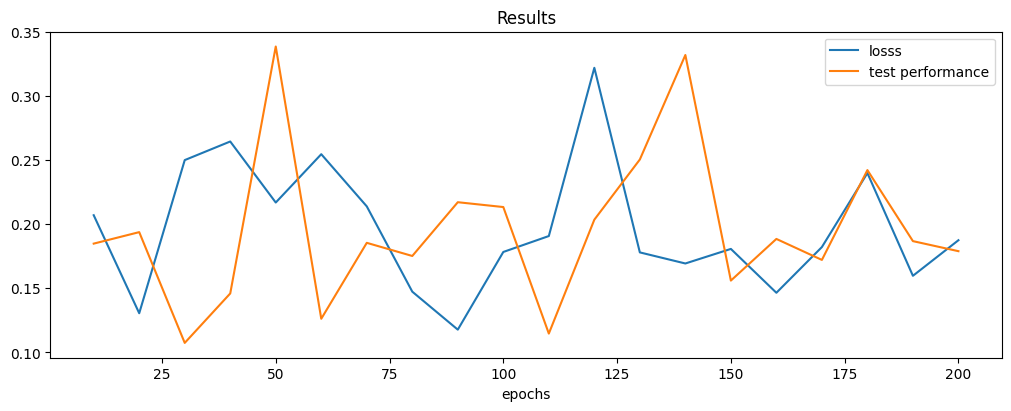

In [100]:
fig, ax = plt.subplots(figsize=(10, 4), layout='constrained')
ax.plot(epoch_list, loss_list, label='losss')  
ax.plot(epoch_list, test_perf_list, label='test performance') 
ax.set_xlabel('epochs')  
ax.set_title("Results") 
ax.legend()

In [104]:
from torchmetrics.classification import BinaryConfusionMatrix

# target, preds = test()
# target_conf.append(target)
# preds_conf.append(preds)



target, pred = evaluate_and_return_confusion()


target_final = torch.tensor(target)
preds_final = torch.tensor(pred)
metric = BinaryConfusionMatrix()
metric(preds_final, target_final)


[tensor([[0.],
        [0.],
        [0.],
        ...,
        [0.],
        [0.],
        [1.]]), tensor([[1.],
        [1.],
        [0.],
        ...,
        [1.],
        [0.],
        [0.]]), tensor([[1.],
        [1.],
        [0.],
        ...,
        [0.],
        [0.],
        [0.]]), tensor([[0.],
        [0.],
        [1.],
        ...,
        [1.],
        [0.],
        [1.]]), tensor([[1.],
        [0.],
        [1.],
        ...,
        [1.],
        [0.],
        [1.]]), tensor([[1.],
        [0.],
        [0.],
        ...,
        [0.],
        [0.],
        [0.]]), tensor([[0.],
        [0.],
        [0.],
        ...,
        [0.],
        [0.],
        [0.]]), tensor([[0.],
        [1.],
        [1.],
        ...,
        [0.],
        [0.],
        [0.]]), tensor([[1.],
        [1.],
        [1.],
        ...,
        [0.],
        [0.],
        [0.]]), tensor([[0.],
        [0.],
        [0.],
        ...,
        [0.],
        [0.],
        [0.]]), tensor([[

ValueError: only one element tensors can be converted to Python scalars

In [42]:
# import torch.nn.functional as F

# def train():
#     for i in range(1, 100):
#         if i % 10 == 0:
#             print(f'Epoch: {i:03d}, Loss: {loss:.4f}')
#         model.train()
#         optimizer.zero_grad()
#         out = model(our_data.x_dict, our_data.edge_index_dict)

#         pred = out['operator']
#         true_label = our_data['operator'].y

#         print(pred[0])
#         # print(true_label)
#         loss = F.binary_cross_entropy_with_logits(pred, true_label)
#         loss.backward()
#         optimizer.step()
#         # return float(loss)

# train()

In [11]:
# def train():
#     model.train()

#     total_examples = total_loss = 0
#     for batch in train_loader:
#         optimizer.zero_grad()
#         batch = batch.to('cuda:0')
#         batch_size = batch['paper'].batch_size
#         out = model(batch.x_dict, batch.edge_index_dict)
#         loss = F.cross_entropy(out['paper'][:batch_size],
#                                batch['paper'].y[:batch_size])
#         loss.backward()
#         optimizer.step()

#         total_examples += batch_size
#         total_loss += float(loss) * batch_size

#     return total_loss / total_examples

In [43]:
# model.eval()

# out = model(our_data.x_dict, our_data.edge_index_dict)
# out["variable"]